# Multilingual Disaster Response Messages - ULMFiT Training

In this notebook, I will fine-tune a ULMFiT model on the [Multilingual Disaster Response Messages](https://appen.com/datasets/combined-disaster-response-data/) dataset. This project is part of the NLP Summit Hackathon 2020.

**Objective:**
- leverage recent advantages in NLP for applications that benefit the social good
- more specifically, use ML and NLP to speed up the processing of disaster response messages and allow text evaluation at scale

**Solution:**
- train text classification models to achieve the goals above
- deploy text classfication models to a simple prototype webapp

**Approach:**
- implement *Universal Language Model Fine-tuning for Text Classification* ([ULMFiT](https://arxiv.org/abs/1801.06146)) by Howard and Ruder with fastai
- fine-tune language model and text classifiers from a pre-trained Wikitext 103 language model
- based on AWD-LSTM architecture, which is very powerful but faster than large scale transformers

**Limitations:**
- this project was developed in very short time and only delivers a working prototype
- **BY NO MEANS SHOULD THE MODEL PREDICTIONS BE USED FOR ACTUAL EVALUATION OF DISASTER REPONSE MESSAGES!!!**

**Credits:**
- [JohnSnowLabs](https://www.johnsnowlabs.com/) for organizing an awesome NLP Summit 2020
- [appen](https://appen.com/) for supplying a very interesting and useful real-world dataset
- [fast.ai](https://www.fast.ai/) for their great deep learning library and online courses
- [paperspace](https://www.paperspace.com/) for making Quadro P5000 GPUs available for free

In [1]:
from fastai.text.all import *
from sklearn.metrics import classification_report

/usr/local/lib/python3.6/dist-packages/fastcore/foundation.py:51: UserWarning: `patch_property` is deprecated and will be removed; use `patch(as_prop=True)` instead
  warnings.warn("`patch_property` is deprecated and will be removed; use `patch(as_prop=True)` instead")


## Data preparation

In [3]:
train_df = pd.read_csv('disaster_response_messages_training.csv', low_memory=False)
valid_df = pd.read_csv('disaster_response_messages_validation.csv', low_memory=False)
test_df = pd.read_csv('disaster_response_messages_test.csv', low_memory=False)

In [4]:
print(f'Training set size: {len(train_df)}')
print(f'Validation set size: {len(valid_df)}')
print(f'Test set size: {len(test_df)}')

Training set size: 21046
Validation set size: 2573
Test set size: 2629


There are 36 categories in the dataset. The number of classes in conjunction with the small size of the dataset make this a very hard multi-label classification problem.

In [5]:
label_cols = list(train_df.columns)[6:]
print(label_cols)

['PII', 'request', 'offer', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 'military', 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report']


I will drop 3 categories that are always zero, so there is nothing to learn from or predict

In [6]:
zero_cols = ['PII', 'offer', 'child_alone']
for c in zero_cols:
    print(train_df[c].value_counts())

0    21046
Name: PII, dtype: int64
0    21046
Name: offer, dtype: int64
0    21046
Name: child_alone, dtype: int64


In [7]:
for c in zero_cols:
    label_cols.remove(c)

In [8]:
print(f'Final number of categories: {len(label_cols)}')

Final number of categories: 33


All other 33 categories are binary with different degrees of class imbalances, some having very few positive labels

In [9]:
for c in label_cols:
    print(train_df[c].value_counts())

0    17486
1     3560
Name: request, dtype: int64
0    12361
1     8685
Name: aid_related, dtype: int64
0    19392
1     1654
Name: medical_help, dtype: int64
0    19975
1     1071
Name: medical_products, dtype: int64
0    20426
1      620
Name: search_and_rescue, dtype: int64
0    20644
1      402
Name: security, dtype: int64
0    20382
1      664
Name: military, dtype: int64
0    19725
1     1321
Name: water, dtype: int64
0    18717
1     2329
Name: food, dtype: int64
0    19168
1     1878
Name: shelter, dtype: int64
0    20723
1      323
Name: clothing, dtype: int64
0    20559
1      487
Name: money, dtype: int64
0    20794
1      252
Name: missing_people, dtype: int64
0    20328
1      718
Name: refugees, dtype: int64
0    20082
1      964
Name: death, dtype: int64
0    18170
1     2876
Name: other_aid, dtype: int64
0    19608
1     1438
Name: infrastructure_related, dtype: int64
0    20098
1      948
Name: transport, dtype: int64
0    19952
1     1094
Name: buildings, dtype: int64

There are some duplicates that need to be dropped

In [10]:
train_df.drop_duplicates(subset=['message'], inplace=True)
valid_df.drop_duplicates(subset=['message'], inplace=True)
len(train_df), len(valid_df)

(20992, 2569)

Just for convenience, I will rename the main text column

In [11]:
train_df.rename(columns={'message':'text'}, inplace=True)
valid_df.rename(columns={'message':'text'}, inplace=True)
test_df.rename(columns={'message':'text'}, inplace=True)

There are no missing values in any of the relevant columns

In [12]:
print(f"Missing values in training set: {train_df[['text']+label_cols].isna().sum().sum()}")
print(f"Missing values in validation set: {valid_df[['text']+label_cols].isna().sum().sum()}")
print(f"Missing values in test set: {test_df[['text']+label_cols].isna().sum().sum()}")

Missing values in training set: 0
Missing values in validation set: 0
Missing values in test set: 0


Since some rows have no label, we'll need to add a none class. 

**Note: Here I make the important assumption that if a record has no disaster label, it is not a post about any disaster. However, in a real-life application, this assumption of course would need to be verified with the creator of the dataset**

In [13]:
train_df['none'] = 1-train_df[label_cols].max(axis=1)
valid_df['none'] = 1-valid_df[label_cols].max(axis=1)
test_df['none'] = 1-test_df[label_cols].max(axis=1)

In [14]:
train_df['none'].value_counts()

0    11720
1     9272
Name: none, dtype: int64

In [15]:
valid_df['none'].value_counts()

0    1397
1    1172
Name: none, dtype: int64

In [16]:
test_df['none'].value_counts()

0    1649
1     980
Name: none, dtype: int64

## Text lenghts

Before moving on to modeling, let's quickly explore text lengths to see what we are dealing with

I define a very simple tokenizer using regex that's not the same as the tokenizer used below. Nevertheless it will give a good indication of how long are texts are approximately

In [17]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [18]:
texts = list(train_df.text.values) + list(valid_df.text.values) + list(test_df.text.values)
len(texts)

26190

In [19]:
lens = []
for t in texts:
    lens.append(len(tokenize(t)))
lens = np.array(lens)

In [20]:
print(f'Average text length: {np.mean(lens)}')

Average text length: 28.458495609011074


In [21]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


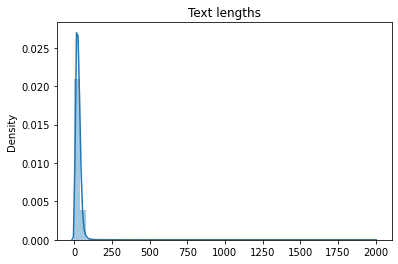

In [22]:
sns.distplot(lens).set_title('Text lengths');

In [23]:
print(f'Maximum text length: {np.max(lens)}')

Maximum text length: 1989


In [24]:
print(f'Text length - 95th percentile: {np.percentile(lens, 95)}')

Text length - 95th percentile: 53.0


The vast majority of texts are very short, with the exception of a few very long texts

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


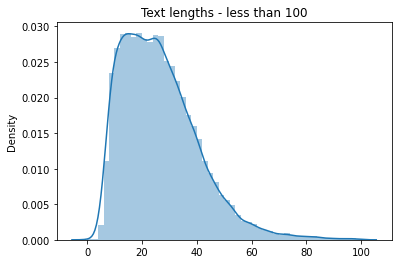

In [25]:
sns.distplot(lens[lens<=100]).set_title('Text lengths - less than 100');

Anyway, since fastai can easily handle varying text lengths by creating batches according to length (with some randomness for training and none for validation/test sets) I leave the texts as is for now.

## Step 1: Language model fine-tuning

Before moving on to training a text classifier, I will fine-tune a pre-trained Wikitext 103 language model on the corpus of the Multilingual Disaster Response Messages dataset.

Since the dataset is quite small and I won't make use of any labels at this stage, I will use all texts for language model fine-tuning

In [26]:
df = pd.concat([train_df, valid_df, test_df]).reset_index(drop=True)
print(f'Total number of documents: {len(df)}')

Total number of documents: 26190


Define batch size and sequence length for backpropagation through time

In [27]:
bs, sl = 128, 80

Create dataloaders with fastai's DataBlock API using a random validation split of 10%. 

Note that the fastai library takes care of text pre-processing behind the scenes, specifically:
- minimal clean up 
- tokenization using spacy's tokenizer
- numericalization and vocab creation 
- training/validation split
- creating dependent and independent variables for language modelling

In [28]:
dblock_lm = DataBlock(blocks=(TextBlock.from_df('text', seq_len=sl, is_lm=True)),
                      get_x=ColReader('text'),
                      splitter=RandomSplitter(0.1))

In [29]:
dls_lm = dblock_lm.dataloaders(df, bs=bs, seq_len=sl)

In [30]:
print(f'Training set size: {len(dls_lm.train_ds)}')
print(f'Validation set size: {len(dls_lm.valid_ds)}')

Training set size: 23571
Validation set size: 2619


In [31]:
print(f'Vocabulary size: {len(dls_lm.vocab)}')

Vocabulary size: 12152


Let's have a look at some examples. One can see that the dependent variable on the right is the input text shifted by one token to the right

In [32]:
dls_lm.show_batch(max_n=3)

,text,text_
0,"xxbos xxmaj according to xxmaj rwanda 's ministry of lands and environment , earthquakes are common in the western xxmaj great xxmaj rift xxmaj valley due to the presence of a seismically active fault line straddling western xxmaj uganda , eastern xxmaj democratic xxmaj republic of xxmaj congo , xxmaj rwanda and xxmaj tanzania . xxbos xxmaj warnings have been issued at several ports in xxmaj tamil xxmaj nadu and xxmaj andhra xxmaj pradesh with rough seas and wind squalls","xxmaj according to xxmaj rwanda 's ministry of lands and environment , earthquakes are common in the western xxmaj great xxmaj rift xxmaj valley due to the presence of a seismically active fault line straddling western xxmaj uganda , eastern xxmaj democratic xxmaj republic of xxmaj congo , xxmaj rwanda and xxmaj tanzania . xxbos xxmaj warnings have been issued at several ports in xxmaj tamil xxmaj nadu and xxmaj andhra xxmaj pradesh with rough seas and wind squalls of"
1,"his office in the western city of xxmaj xxunk . xxbos xxmaj we need shelter in xxunk xxunk cross bb blanc street xxbos xxmaj the xxmaj pentagon was reported as saying on 21st xxmaj december that it was sending 10 experimental "" xxunk "" bombs to xxmaj afghanistan to blast the air out of caves and underground facilities . xxbos xxup dec member agencies are urgently seeking to increase their work to help those at risk survive and put their","office in the western city of xxmaj xxunk . xxbos xxmaj we need shelter in xxunk xxunk cross bb blanc street xxbos xxmaj the xxmaj pentagon was reported as saying on 21st xxmaj december that it was sending 10 experimental "" xxunk "" bombs to xxmaj afghanistan to blast the air out of caves and underground facilities . xxbos xxup dec member agencies are urgently seeking to increase their work to help those at risk survive and put their lives"
2,"unidentified gunmen shot dead a xxmaj muslim civilian at xxmaj xxunk xxmaj lane in xxmaj xxunk , a xxunk about 06 km off the xxmaj trincomalee town . xxbos xxunk yes unless we continue to be without power . # xxunk # blackout # xxmaj sandy xxbos a storm is a coming xxunk xxmaj waterway xxmaj ferry xxmaj terminal xxmaj wall xxmaj street / xxmaj pier 11 http : / / t.co / xxunk get much more xxunk , the","gunmen shot dead a xxmaj muslim civilian at xxmaj xxunk xxmaj lane in xxmaj xxunk , a xxunk about 06 km off the xxmaj trincomalee town . xxbos xxunk yes unless we continue to be without power . # xxunk # blackout # xxmaj sandy xxbos a storm is a coming xxunk xxmaj waterway xxmaj ferry xxmaj terminal xxmaj wall xxmaj street / xxmaj pier 11 http : / / t.co / xxunk get much more xxunk , the xxunk"


Setting up fastai learner with dataloaders, AWD-LSTM architecture, default dropout, and accuracy and perplexity metrics. Also, in order to speed up training I will use mixed-precision training using the `to_fp16()` callback. By default, fastai uses `pretrained=True`, which means a pre-trained Wikitext 103 language model is loaded behind the scenes.

In [33]:
learn = language_model_learner(dls_lm, AWD_LSTM, drop_mult=1.0, metrics=[accuracy, Perplexity()]).to_fp16()

Picking the learning rate where the learning rate finder curve is the steppest

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.05754399299621582)

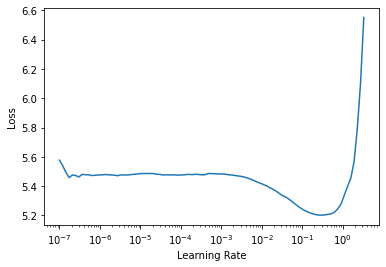

In [34]:
learn.lr_find()

`fine_tune` first trains the embedding layer for one epoch with the rest of the model fixed, then unfreezes all parameters and fine-tunes the entire model

In [35]:
learn.fine_tune(10, 6e-2, wd=0.1)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.595785,4.327098,0.256053,75.724205,00:46


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.991463,3.736517,0.323928,41.951614,00:51
1,3.866527,3.785379,0.310167,44.052380,00:52
2,3.784130,3.807200,0.312047,45.024216,00:51
3,3.689517,3.732308,0.322022,41.775402,00:52
4,3.571326,3.688126,0.330191,39.969887,00:57
5,3.437598,3.639495,0.336882,38.072609,00:58
6,3.304376,3.594979,0.344750,36.414928,00:55
7,3.163026,3.578991,0.348934,35.837376,00:51
8,3.055540,3.577392,0.350558,35.780090,00:51
9,2.975360,3.581739,0.350329,35.935986,00:51


Saving the encoder of the model for creating text classifiers below

In [36]:
learn.save_encoder('disaster_lm_enc')

...and the vocab that the model was trained on

In [37]:
output = open('dls_lm.pkl', 'wb')
pickle.dump(dls_lm, output)
output.close()

## Step 2: Simple disaster classification

Before building a text classifier for all classes, I want to build a model that simply predicts if a given document has any label or none. In other words, that's the 'none' column I created above.

Loading the vocab from step 1

In [42]:
pkl_file = open('dls_lm.pkl', 'rb')
dls_lm = pickle.load(pkl_file)
pkl_file.close()

In [43]:
train_df['is_valid'] = False
valid_df['is_valid'] = True
df = pd.concat([train_df, valid_df]).reset_index(drop=True)

In [44]:
dblock = DataBlock(blocks=(TextBlock.from_df('text', seq_len=sl, vocab=dls_lm.vocab), CategoryBlock),
                      get_x=ColReader('text'),
                      get_y=ColReader('none'),
                      splitter=ColSplitter('is_valid'))

In [45]:
dls_cls = dblock.dataloaders(df, bs=bs, seq_len=sl)

In [46]:
print(f'Training set size: {len(dls_cls.train_ds)}')
print(f'Validation set size: {len(dls_cls.valid_ds)}')

Training set size: 20992
Validation set size: 2569


In [61]:
learn = text_classifier_learner(dls_cls, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, F1Score(average='macro')]).to_fp16()

In [62]:
learn.load_encoder('disaster_lm_enc');

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.0004786300996784121)

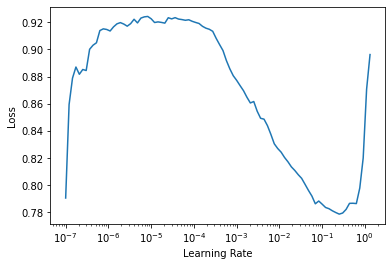

In [63]:
learn.lr_find()

Define maximum learning rate for one-cycle training, number of epochs for each step of gradual unfreezing and amount weight decay. 

Gradual unfreezing was introduced in the ULMFiT paper and starts by only training the randomly initialized classification head, then unfreezing one layer after another before training the entire model.

In [64]:
lr, n_epoch, wd = 2e-2, 1, 0.01

In [65]:
learn.fit_one_cycle(n_epoch, lr, wd=wd)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.657334,0.479546,0.769171,0.761387,00:12


In [66]:
learn.freeze_to(-2)
learn.fit_one_cycle(n_epoch, slice((lr/2)/(2.6**4),lr/2), wd=wd)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.541488,0.451184,0.786687,0.780915,00:14


In [67]:
learn.freeze_to(-3)
learn.fit_one_cycle(n_epoch, slice((lr/4)/(2.6**4),lr/4), wd=wd)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.471611,0.437064,0.792137,0.786174,00:19


In [68]:
learn.unfreeze()
learn.fit_one_cycle(n_epoch*2, slice((lr/10)/(2.6**4),lr/10), wd=wd)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.431984,0.444675,0.799144,0.792931,00:24
1,0.386458,0.453244,0.803036,0.797654,00:25


Looking at validation set results in detail

In [94]:
probs, targs = learn.get_preds()

In [95]:
print(classification_report(targs.numpy(), probs.argmax(1).numpy()))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83      1397
           1       0.84      0.70      0.76      1172

    accuracy                           0.80      2569
   macro avg       0.81      0.79      0.80      2569
weighted avg       0.81      0.80      0.80      2569



We can see a very good performance on the validation set. A recall of 0.89 for class 0 means that nearly 90% of documents with a label were correctly classified as such, which is the metric we should most care about. Let's see if the results hold up for the test set.

In [108]:
test_dl = learn.dls.test_dl(test_df)

In [109]:
probs,_ = learn.get_preds(dl=test_dl)

In [110]:
preds = probs.argmax(1)
len(preds)

2629

In [111]:
print(classification_report(test_df['none'].values, preds.numpy()))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1649
           1       0.76      0.79      0.77       980

    accuracy                           0.83      2629
   macro avg       0.82      0.82      0.82      2629
weighted avg       0.83      0.83      0.83      2629



The recall on the test set is a bit lower, but 0.85 still is a very good performance

Let's export the model for deployment

In [77]:
learn.export()

## Step 3: Multi-label classification

Now I will turn to the much harder prediction problem of classifying 33 detailed classes with one model. Apart from a few tweaks to enable multi-label classification, the code is much the same as in step 2.

In [112]:
pkl_file = open('dls_lm.pkl', 'rb')
dls_lm = pickle.load(pkl_file)
pkl_file.close()

Since I will use the first classifer to filter out documents without any label before applying the multi-label classifier, I need to remove all reviews without label from the training, validation and test sets.

In [114]:
train_df = train_df[train_df['none']==0].reset_index(drop=True)
valid_df = valid_df[valid_df['none']==0].reset_index(drop=True)
test_df = test_df[test_df['none']==0].reset_index(drop=True)
len(train_df), len(valid_df), len(test_df)

(11720, 1397, 1649)

In [226]:
train_df['is_valid'] = False
valid_df['is_valid'] = True
df = pd.concat([train_df, valid_df]).reset_index(drop=True)

In one more step, I will create one column with all labels for each document

In [227]:
def create_label_col(df):
    label_list = []
    for i in range(len(df)):
        labels = ''
        for c in label_cols:
            if df.loc[i,c] == 1:
                if labels == '':
                    labels = labels + str(c)
                else:
                    labels = labels + ' ' + str(c)
        label_list.append(labels)
    assert len(label_list) == len(df)
    return label_list

In [228]:
label_list = create_label_col(df)
df['multi_label'] = label_list

In [229]:
label_list[:5]

['aid_related other_aid weather_related storm',
 'weather_related storm',
 'request aid_related water shelter direct_report',
 'request aid_related medical_help medical_products water food other_aid infrastructure_related transport buildings other_infrastructure weather_related floods direct_report',
 'request aid_related water direct_report']

In [230]:
dblock = DataBlock(blocks=(TextBlock.from_df('text', seq_len=sl, vocab=dls_lm.vocab), MultiCategoryBlock),
                      get_x=ColReader('text'),
                      get_y=ColReader('multi_label', label_delim=' '),
                      splitter=ColSplitter('is_valid'))

In [231]:
dls_cls = dblock.dataloaders(df, bs=bs, seq_len=sl)

In [232]:
print(f'Training set size: {len(dls_cls.train_ds)}')
print(f'Validation set size: {len(dls_cls.valid_ds)}')

Training set size: 11720
Validation set size: 1397


Since the evaluation of disaster response messages is a very sensitive and critical endeavour, I set the threshold very low. This way, if the model has at lease *some* confidence that a class is present, it will be accepted.

In [233]:
thresh = 0.2
accuracy_thresh = partial(accuracy_multi, thresh=thresh)
f1_thresh = F1ScoreMulti(average='macro', thresh=thresh)
metrics = [accuracy_thresh, f1_thresh]

In [234]:
learn = text_classifier_learner(dls_cls, AWD_LSTM, drop_mult=0.5, metrics=metrics).to_fp16()

In [235]:
learn.load_encoder('disaster_lm_enc');

SuggestedLRs(lr_min=0.10964782238006592, lr_steep=0.0691830962896347)

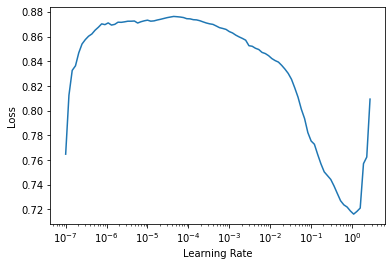

In [236]:
learn.lr_find()

In [237]:
lr, n_epoch, wd = 7e-2, 1, 0.01

In [238]:
learn.fit_one_cycle(n_epoch, lr, wd=wd)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,time
0,0.420509,0.226203,0.891239,0.410004,00:07


In [239]:
learn.freeze_to(-2)
learn.fit_one_cycle(n_epoch, slice((lr/2)/(2.6**4),lr/2), wd=wd)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,time
0,0.245216,0.207718,0.901152,0.469845,00:09


In [240]:
learn.freeze_to(-3)
learn.fit_one_cycle(n_epoch, slice((lr/4)/(2.6**4),lr/4), wd=wd)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,time
0,0.208510,0.197499,0.909720,0.503707,00:12


In [241]:
learn.unfreeze()
learn.fit_one_cycle(n_epoch*4, slice((lr/10)/(2.6**4),lr/10), wd=wd)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,time
0,0.194964,0.194242,0.913017,0.511478,00:15
1,0.188168,0.192489,0.914579,0.527072,00:15
2,0.179171,0.191317,0.913386,0.530661,00:15
3,0.169535,0.191881,0.909503,0.527831,00:15


In [242]:
probs, targs = learn.get_preds()
probs.shape, targs.shape

(torch.Size([1397, 33]), torch.Size([1397, 33]))

In [243]:
preds = probs > thresh
targs = targs.to(bool)

In [245]:
print(classification_report(targs, preds, target_names=dls_cls.vocab[1]))

                        precision    recall  f1-score   support

           aid_centers       0.31      0.31      0.31        36
           aid_related       0.79      0.98      0.88      1048
             buildings       0.53      0.72      0.61       126
              clothing       0.58      0.48      0.52        46
                  cold       0.52      0.62      0.56        60
                 death       0.54      0.70      0.61       108
         direct_report       0.68      0.84      0.75       457
            earthquake       0.88      0.86      0.87       249
           electricity       0.48      0.67      0.56        43
                  fire       0.53      0.31      0.39        32
                floods       0.56      0.70      0.62       214
                  food       0.80      0.88      0.84       275
             hospitals       0.38      0.30      0.33        37
infrastructure_related       0.37      0.61      0.46       188
          medical_help       0.57      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Given the number of classes, I am not going to describe the results in detail. To sum it up, I would evaluate the performance as pretty good given the small amount of training data and the high number of classes.

For some classes, e.g. aid_related, earthquake, food, storm or weather-related, the recall is very high and could probably be used in practice. For other classes, e.g. missing people, shops and tools, the classifier is not working at all. However, this is no surprise since those are the classes where we have nearly no labels available.

### Re-training and evaluating on test set

Because the training set for the multi-label classification problem is very small, I will retrain the classifier on training and validation sets and evaluate on the test set. Let's see if performance holds up.

In [246]:
train_df['is_valid'] = False
valid_df['is_valid'] = False
test_df['is_valid'] = True
df = pd.concat([train_df, valid_df, test_df]).reset_index(drop=True)

In [247]:
label_list = create_label_col(df)
df['multi_label'] = label_list

In [248]:
dblock = DataBlock(blocks=(TextBlock.from_df('text', seq_len=sl, vocab=dls_lm.vocab), MultiCategoryBlock),
                      get_x=ColReader('text'),
                      get_y=ColReader('multi_label', label_delim=' '),
                      splitter=ColSplitter('is_valid'))

In [249]:
dls_cls = dblock.dataloaders(df, bs=bs, seq_len=sl)

In [251]:
print(f'Training set size: {len(dls_cls.train_ds)}')
print(f'Test set size: {len(dls_cls.valid_ds)}')

Training set size: 13117
Test set size: 1649


In [252]:
learn = text_classifier_learner(dls_cls, AWD_LSTM, drop_mult=0.5, metrics=metrics).to_fp16()

In [253]:
learn.load_encoder('disaster_lm_enc');

In [254]:
learn.fit_one_cycle(n_epoch, lr, wd=wd)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,time
0,0.399075,0.178525,0.898800,0.416585,00:08


In [255]:
learn.freeze_to(-2)
learn.fit_one_cycle(n_epoch, slice((lr/2)/(2.6**4),lr/2), wd=wd)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,time
0,0.237831,0.161469,0.908907,0.463480,00:09


In [256]:
learn.freeze_to(-3)
learn.fit_one_cycle(n_epoch, slice((lr/4)/(2.6**4),lr/4), wd=wd)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,time
0,0.210125,0.150296,0.915266,0.512121,00:13


In [257]:
learn.unfreeze()
learn.fit_one_cycle(n_epoch*4, slice((lr/10)/(2.6**4),lr/10), wd=wd)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,time
0,0.194884,0.145594,0.920319,0.522289,00:17
1,0.190628,0.142574,0.923994,0.535333,00:17
2,0.179959,0.141083,0.921789,0.538923,00:17
3,0.171423,0.141557,0.921973,0.536780,00:17


In [258]:
probs, targs = learn.get_preds()
probs.shape, targs.shape

(torch.Size([1649, 33]), torch.Size([1649, 33]))

In [260]:
preds = probs > thresh
targs = targs.to(bool)

In [262]:
print(classification_report(targs, preds, target_names=dls_cls.vocab[1]))

                        precision    recall  f1-score   support

           aid_centers       0.08      0.13      0.10        15
           aid_related       0.76      0.99      0.86      1145
             buildings       0.51      0.78      0.62       115
              clothing       0.56      0.62      0.59        37
                  cold       0.58      0.84      0.68        45
                 death       0.65      0.77      0.70       124
         direct_report       0.71      0.84      0.77       615
            earthquake       0.85      0.93      0.89       227
           electricity       0.51      0.76      0.61        42
                  fire       0.38      0.55      0.44        11
                floods       0.61      0.71      0.66       246
                  food       0.89      0.86      0.87       326
             hospitals       0.40      0.56      0.47        18
infrastructure_related       0.17      0.62      0.27        79
          medical_help       0.52      

It seems like the model even performed slightly better than on the validation set. However, keep in mind that it also was trained on a larger amount of data. 

Exporting the final model

In [263]:
learn.export('export_multi.pkl')

### end